<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/master/LWFMain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys


In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1586 (delta 48), reused 0 (delta 0), pack-reused 1499
Receiving objects: 100% (1586/1586), 1.20 MiB | 2.84 MiB/s, done.
Resolving deltas: 100% (1012/1012), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Network

In [5]:
resNet = ResNet.resnet32(num_classes=100)
resNet = resNet.to(params.DEVICE)

In [6]:
train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define DataSets

In [7]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [8]:
train_splits = trainDS.splits
test_splits = testDS.splits
print(train_splits)
print(test_splits)

[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.0, 95.0, 25.0, 47.0, 34.0, 52.0, 44.0, 72.0], [46.0, 79.0, 20.0, 28.0, 5.0, 71.0, 8.0, 18.0, 33.0, 15.0], [55.0, 29.0, 64.0, 31.0, 67.0, 7.0, 13.0, 14.0, 42.0, 6.0], [82.0, 2.0, 27.0, 16.0, 26.0, 3.0, 4.0, 1.0, 9.0, 0.0]]
[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.

# Useful plots

The function plotEpoch plots, at the end of each task, how accuracy and loss change during the training phase. It show

*   Validation and Training Accuracy
*   Validation and Training Loss

The function plotTask, for each task, how the accuracy on the validation set change when adding new tasks


In [9]:
def plotTask(pars_tasks):
  import numpy as np
  import matplotlib.pyplot as plt

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy', 'Loss'])
  plt.xlabel("Epoch")
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy', 'Loss'])
  plt.grid(True)
  plt.show()



# Train and evaluation phase

task = 0 
train col =  [94 63 74 21 35 56 91 96 87 48]
train col =  [[94 63 74 21 35 56 91 96 87 48]]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


At step  0  and at epoch =  0  the loss is =  0.03131084516644478  and accuracy is =  0.2032
At step  0  and at epoch =  1  the loss is =  0.02456929348409176  and accuracy is =  0.3912
At step  0  and at epoch =  2  the loss is =  0.020439621061086655  and accuracy is =  0.4802
At step  0  and at epoch =  3  the loss is =  0.021487491205334663  and accuracy is =  0.5188
At step  0  and at epoch =  4  the loss is =  0.021698879078030586  and accuracy is =  0.5832
At step  0  and at epoch =  5  the loss is =  0.027730297297239304  and accuracy is =  0.6142
At step  0  and at epoch =  6  the loss is =  0.021133260801434517  and accuracy is =  0.6364
At step  0  and at epoch =  7  the loss is =  0.018932903185486794  and accuracy is =  0.6614
At step  0  and at epoch =  8  the loss is =  0.010277723893523216  and accuracy is =  0.681
At step  0  and at epoch =  9  the loss is =  0.010110793635249138  and accuracy is =  0.7126
At step  0  and at epoch =  10  the loss is =  0.01151546090841

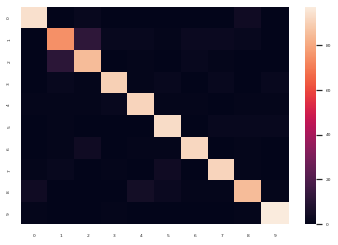

task = 10 
train col =  [68 80 22 37 60 97 51 62 92 76]
train col =  [[68 80 22 37 60 97 51 62 92 76]]
At step  10  and at epoch =  0  the loss is =  0.05901963636279106  and accuracy is =  0.3208
At step  10  and at epoch =  1  the loss is =  0.04988311603665352  and accuracy is =  0.5658
At step  10  and at epoch =  2  the loss is =  0.029300548136234283  and accuracy is =  0.6426
At step  10  and at epoch =  3  the loss is =  0.02660852111876011  and accuracy is =  0.6738
At step  10  and at epoch =  4  the loss is =  0.04694195091724396  and accuracy is =  0.7196
At step  10  and at epoch =  5  the loss is =  0.033906228840351105  and accuracy is =  0.7284
At step  10  and at epoch =  6  the loss is =  0.039162226021289825  and accuracy is =  0.7514
At step  10  and at epoch =  7  the loss is =  0.052113283425569534  and accuracy is =  0.7642
At step  10  and at epoch =  8  the loss is =  0.03883122280240059  and accuracy is =  0.7842
At step  10  and at epoch =  9  the loss is =  

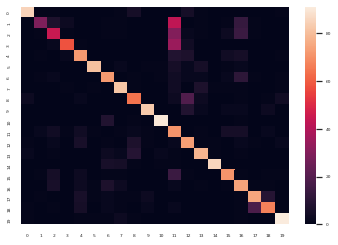

task = 20 
train col =  [75 89 23 99 39 66 54 69 84 61]
train col =  [[75 89 23 99 39 66 54 69 84 61]]
At step  20  and at epoch =  0  the loss is =  0.05711307376623154  and accuracy is =  0.4752
At step  20  and at epoch =  1  the loss is =  0.04941917210817337  and accuracy is =  0.677
At step  20  and at epoch =  2  the loss is =  0.062126416712999344  and accuracy is =  0.7282
At step  20  and at epoch =  3  the loss is =  0.05902296304702759  and accuracy is =  0.7454
At step  20  and at epoch =  4  the loss is =  0.05397319793701172  and accuracy is =  0.7776
At step  20  and at epoch =  5  the loss is =  0.04827037826180458  and accuracy is =  0.8032
At step  20  and at epoch =  6  the loss is =  0.07012621313333511  and accuracy is =  0.8324
At step  20  and at epoch =  7  the loss is =  0.052230414003133774  and accuracy is =  0.8292
At step  20  and at epoch =  8  the loss is =  0.06121755391359329  and accuracy is =  0.842
At step  20  and at epoch =  9  the loss is =  0.04

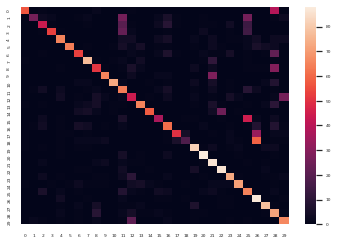

task = 30 
train col =  [85 24 98 41 73 58 78 77 70 49]
train col =  [[85 24 98 41 73 58 78 77 70 49]]
At step  30  and at epoch =  0  the loss is =  0.07642265409231186  and accuracy is =  0.5344
At step  30  and at epoch =  1  the loss is =  0.07681720703840256  and accuracy is =  0.7216
At step  30  and at epoch =  2  the loss is =  0.06860294938087463  and accuracy is =  0.7728
At step  30  and at epoch =  3  the loss is =  0.05879072844982147  and accuracy is =  0.8088
At step  30  and at epoch =  4  the loss is =  0.07045311480760574  and accuracy is =  0.8248
At step  30  and at epoch =  5  the loss is =  0.0734025090932846  and accuracy is =  0.841
At step  30  and at epoch =  6  the loss is =  0.0776405856013298  and accuracy is =  0.8476
At step  30  and at epoch =  7  the loss is =  0.06723006069660187  and accuracy is =  0.8622
At step  30  and at epoch =  8  the loss is =  0.0908077284693718  and accuracy is =  0.8664
At step  30  and at epoch =  9  the loss is =  0.071440

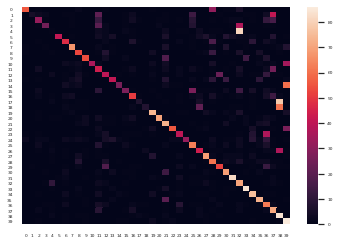

task = 40 
train col =  [65 88 36 93 45 10 90 17 32 59]
train col =  [[65 88 36 93 45 10 90 17 32 59]]
At step  40  and at epoch =  0  the loss is =  0.08962806314229965  and accuracy is =  0.461
At step  40  and at epoch =  1  the loss is =  0.10782615095376968  and accuracy is =  0.6368
At step  40  and at epoch =  2  the loss is =  0.09693265706300735  and accuracy is =  0.6842
At step  40  and at epoch =  3  the loss is =  0.10667986422777176  and accuracy is =  0.7176
At step  40  and at epoch =  4  the loss is =  0.08911720663309097  and accuracy is =  0.7306
At step  40  and at epoch =  5  the loss is =  0.08487051725387573  and accuracy is =  0.7334
At step  40  and at epoch =  6  the loss is =  0.09734147042036057  and accuracy is =  0.771
At step  40  and at epoch =  7  the loss is =  0.09817860275506973  and accuracy is =  0.7782
At step  40  and at epoch =  8  the loss is =  0.08176587522029877  and accuracy is =  0.79
At step  40  and at epoch =  9  the loss is =  0.085636

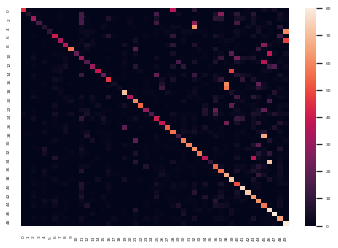

task = 50 
train col =  [83 43 53 11 86 19 38 30 40 50]
train col =  [[83 43 53 11 86 19 38 30 40 50]]
At step  50  and at epoch =  0  the loss is =  0.1069227010011673  and accuracy is =  0.5194
At step  50  and at epoch =  1  the loss is =  0.1202515959739685  and accuracy is =  0.6872
At step  50  and at epoch =  2  the loss is =  0.09859277307987213  and accuracy is =  0.7362
At step  50  and at epoch =  3  the loss is =  0.11367853730916977  and accuracy is =  0.7676
At step  50  and at epoch =  4  the loss is =  0.10748067498207092  and accuracy is =  0.7694
At step  50  and at epoch =  5  the loss is =  0.09692554175853729  and accuracy is =  0.7962
At step  50  and at epoch =  6  the loss is =  0.10897453129291534  and accuracy is =  0.8086
At step  50  and at epoch =  7  the loss is =  0.11137715727090836  and accuracy is =  0.8094
At step  50  and at epoch =  8  the loss is =  0.12507574260234833  and accuracy is =  0.8248
At step  50  and at epoch =  9  the loss is =  0.1012

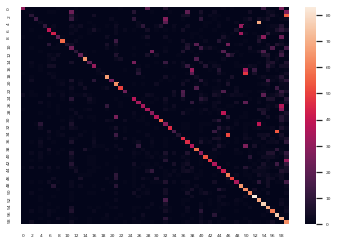

task = 60 
train col =  [57 81 12 95 25 47 34 52 44 72]
train col =  [[57 81 12 95 25 47 34 52 44 72]]
At step  60  and at epoch =  0  the loss is =  0.12751027941703796  and accuracy is =  0.5846
At step  60  and at epoch =  1  the loss is =  0.1431298553943634  and accuracy is =  0.727
At step  60  and at epoch =  2  the loss is =  0.12913689017295837  and accuracy is =  0.7426
At step  60  and at epoch =  3  the loss is =  0.11615807563066483  and accuracy is =  0.7718
At step  60  and at epoch =  4  the loss is =  0.12856850028038025  and accuracy is =  0.7828
At step  60  and at epoch =  5  the loss is =  0.12638336420059204  and accuracy is =  0.794
At step  60  and at epoch =  6  the loss is =  0.12231677770614624  and accuracy is =  0.8092
At step  60  and at epoch =  7  the loss is =  0.13423241674900055  and accuracy is =  0.814
At step  60  and at epoch =  8  the loss is =  0.10852723568677902  and accuracy is =  0.8144
At step  60  and at epoch =  9  the loss is =  0.114759

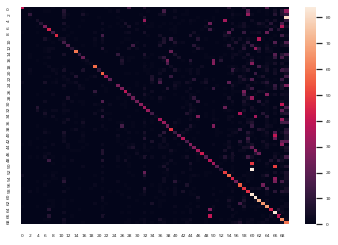

task = 70 
train col =  [46 79 20 28  5 71  8 18 33 15]
train col =  [[46 79 20 28  5 71  8 18 33 15]]
At step  70  and at epoch =  0  the loss is =  0.14500485360622406  and accuracy is =  0.5736
At step  70  and at epoch =  1  the loss is =  0.15518954396247864  and accuracy is =  0.757
At step  70  and at epoch =  2  the loss is =  0.14334318041801453  and accuracy is =  0.797
At step  70  and at epoch =  3  the loss is =  0.15423773229122162  and accuracy is =  0.8136
At step  70  and at epoch =  4  the loss is =  0.14720164239406586  and accuracy is =  0.8354
At step  70  and at epoch =  5  the loss is =  0.14522337913513184  and accuracy is =  0.8402
At step  70  and at epoch =  6  the loss is =  0.1658078283071518  and accuracy is =  0.8544
At step  70  and at epoch =  7  the loss is =  0.14515164494514465  and accuracy is =  0.8682
At step  70  and at epoch =  8  the loss is =  0.13491754233837128  and accuracy is =  0.8776
At step  70  and at epoch =  9  the loss is =  0.14701

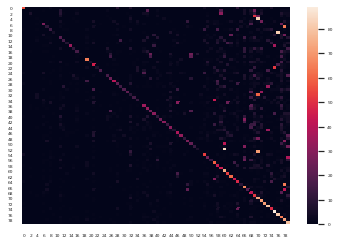

task = 80 
train col =  [55 29 64 31 67  7 13 14 42  6]
train col =  [[55 29 64 31 67  7 13 14 42  6]]
At step  80  and at epoch =  0  the loss is =  0.1640389859676361  and accuracy is =  0.4956
At step  80  and at epoch =  1  the loss is =  0.1607189178466797  and accuracy is =  0.6648
At step  80  and at epoch =  2  the loss is =  0.16230067610740662  and accuracy is =  0.6944
At step  80  and at epoch =  3  the loss is =  0.1941293478012085  and accuracy is =  0.722
At step  80  and at epoch =  4  the loss is =  0.18479548394680023  and accuracy is =  0.7368
At step  80  and at epoch =  5  the loss is =  0.20186668634414673  and accuracy is =  0.7476
At step  80  and at epoch =  6  the loss is =  0.17228934168815613  and accuracy is =  0.7566
At step  80  and at epoch =  7  the loss is =  0.15839597582817078  and accuracy is =  0.7744
At step  80  and at epoch =  8  the loss is =  0.1786557137966156  and accuracy is =  0.793
At step  80  and at epoch =  9  the loss is =  0.14796455

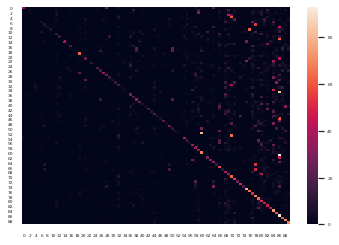

task = 90 
train col =  [82  2 27 16 26  3  4  1  9  0]
train col =  [[82  2 27 16 26  3  4  1  9  0]]
At step  90  and at epoch =  0  the loss is =  0.20550261437892914  and accuracy is =  0.5608
At step  90  and at epoch =  1  the loss is =  0.1912657916545868  and accuracy is =  0.7148
At step  90  and at epoch =  2  the loss is =  0.215880885720253  and accuracy is =  0.7514
At step  90  and at epoch =  3  the loss is =  0.19856250286102295  and accuracy is =  0.7672
At step  90  and at epoch =  4  the loss is =  0.19278430938720703  and accuracy is =  0.793
At step  90  and at epoch =  5  the loss is =  0.19859077036380768  and accuracy is =  0.8014
At step  90  and at epoch =  6  the loss is =  0.20640945434570312  and accuracy is =  0.8138
At step  90  and at epoch =  7  the loss is =  0.19221274554729462  and accuracy is =  0.822
At step  90  and at epoch =  8  the loss is =  0.2068977653980255  and accuracy is =  0.8294
At step  90  and at epoch =  9  the loss is =  0.16711799

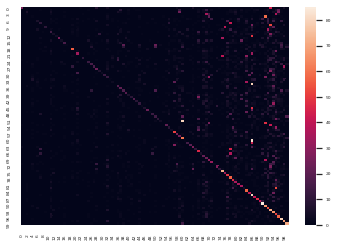

In [10]:
pars_tasks = []
test_indexes = []

for task in range(0, 100, params.TASK_SIZE):
  pars_tasks.insert(task, 0)

for task in range(0, 100, params.TASK_SIZE):

  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, train_transformer)
  test_dataset = Subset(testDS, test_indexes, test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle = True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle = True )

  if(task == 0):
    torch.save(resNet, 'resNet_task{0}.pt'.format(task))
  
  

  utils.trainfunction(task, train_loader, train_splits)
  param = utils.evaluationTest(task, test_loader, test_splits)
  pars_tasks[int(task/10)] = param #pars_task[i] = (accuracy, loss) at i-th task

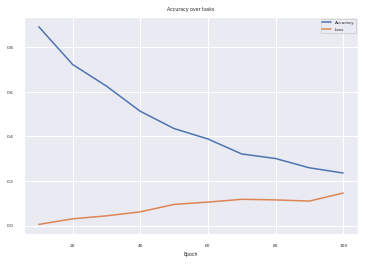

In [11]:
plotTask(pars_tasks)